In [1]:
%matplotlib inline

import pandas as pd
import locale
locale.setlocale(locale.LC_TIME,'fr_FR.UTF-8')
import matplotlib.pyplot as plt
from matplotlib import animation, ticker, rc
import matplotlib._color_data as mcd
import random as rd
from IPython.display import HTML, Image

In [2]:
rc('animation', html='html5') # Juste pour sépcifier que le format de l'animation soit compatible à html5

In [3]:
dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

In [4]:
cases = pd.read_csv(dir+'time_series_covid19_confirmed_global.csv')

In [5]:
west_af_country = ['Benin', 'Burkina Faso', 'Cabo Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo']

cent_af_country = ['Cameroon', 'Central African Republic', 'Chad', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']

In [6]:
westaf_cases = cases.loc[cases['Country/Region'].isin(west_af_country)].copy().fillna('')
centaf_cases = cases.loc[cases['Country/Region'].isin(cent_af_country)].copy().fillna('')

On va modifier rapidement certains noms des pays afin de nous assurer que le tout soit en français et pas très longs.

In [7]:
westaf_cases['Country/Region'] = westaf_cases['Country/Region'].replace({'Benin' : 'Bénin', 
                                                                         'Cabo Verde' : 'Cap-Vert', 
                                                                         'Gambia' : 'Gambie', 
                                                                         'Guinea' : 'Guinée', 
                                                                         'Guinea-Bissau' : 'Guinée-Bissau', 
                                                                         'Liberia' : 'Libéria', 
                                                                         'Mauritania' : 'Mauritanie', 
                                                                         'Senegal' : 'Sénégal'})

centaf_cases['Country/Region'] = centaf_cases['Country/Region'].replace({'Cameroon' : 'Caméroun', 
                                                                          'Central African Republic' : 'Centrafrique', 
                                                                          'Chad' : 'Tchad', 
                                                                          'Congo (Brazzaville)' : 'Congo Brazza', 
                                                                          'Congo (Kinshasa)' : 'Congo Kinsh', 
                                                                          'Equatorial Guinea' : 'Guinée Équatoriale', 
                                                                          'Sao Tome and Principe' : 'Sao-Tomé'})

In [8]:
def trans_ts(df):
    df_trans = df.drop(columns=['Province/State','Lat','Long']).rename(columns={'Country/Region':' '}).set_index(' ').transpose()
    df_trans.index = pd.to_datetime(df_trans.index)
    return(df_trans)

In [9]:
westaf_ts = trans_ts(westaf_cases)
centaf_ts = trans_ts(centaf_cases)

On va rajouter la date en format texte et en langue française afin que tout le monde puisse se retrouver. Aussi grâce à la date, on pourra connaitre le quelième jour de l'année l'observation a été effectuée. Ex : Le 1er février est le 32ème jour de l'année.

In [10]:
westaf_ts = westaf_ts.loc[westaf_ts.loc[westaf_ts.sum(axis=1)>0].index]
westaf_ts['jour_an'] = westaf_ts.index.dayofyear
westaf_ts['date'] = westaf_ts.index.strftime('%A %d %B %Y')
westaf_ts['date'] = westaf_ts['date'].str.title()

centaf_ts = centaf_ts.loc[centaf_ts.loc[centaf_ts.sum(axis=1)>0].index]
centaf_ts['date'] = centaf_ts.index.strftime('%A %d %B %Y')
centaf_ts['date'] = centaf_ts['date'].str.title()
centaf_ts['jour_an'] = centaf_ts.index.dayofyear

Ici je combine les données des deux zones ensemble afin d'en faire finalement une table unique. Je modifie aussi un peu la structure de la table. Désormais c'est la colonne 'Cas' qui va contenir les nombres de cas et non la colonne au nom du pays. J'ai créé une nouvelle colonne 'Pays' pour préciser le nom du pays observé désormais par ligne. Les dates et le nombre de jour sont maintenus, juste répétés désormais par pays.

In [11]:
west_cent = pd.DataFrame()
for i in centaf_ts.columns[:-2]:
    vars()[i] = centaf_ts[[i, 'jour_an', 'date']].copy().reset_index(drop = True)
    vars()[i].columns = ['Cas', 'Jour', 'Date']
    vars()[i]['Pays'] = i
    vars()[i]['Region'] = 'Centre'
    west_cent = west_cent.append(vars()[i])
for j in westaf_ts.columns[:-2]:
    vars()[j] = westaf_ts[[j, 'jour_an', 'date']].copy().reset_index(drop = True)
    vars()[j].columns = ['Cas', 'Jour', 'Date']
    vars()[j]['Pays'] = j
    vars()[j]['Region'] = "Ouest"
    west_cent = west_cent.append(vars()[j])

In [12]:
#region_dic = west_cent.set_index('Pays')['Region'].to_dict()
date_dic = west_cent.set_index('Jour')['Date'].to_dict()

J'aurais besoin plus tard d'utiliser une couleur unique par pays. le code suivant me permet de spécifier de façon aléatoire une couleur pour chacun des pays dans la liste. Même si les données changent, il détectera automatiquement le nouveau nombre de pays et effectuera le travail.

In [13]:
couleur_dic = dict(zip(west_cent['Pays'].unique(), rd.sample(list(mcd.CSS4_COLORS.values()), len(west_cent['Pays'].unique()))))

Les diagrammes à bande animés que nous voyons ne sont en réalité que plusieurs diagrammes visualisés les uns après les autres. Le code suivant me permettra de visualiser le diagramme de la dernière journée de donnée que je dispose : le samedi 9 mai. Celui d'après permet de généraliser la visualisation sur toutes les journées de notre table de donnée et de générer l'animation.

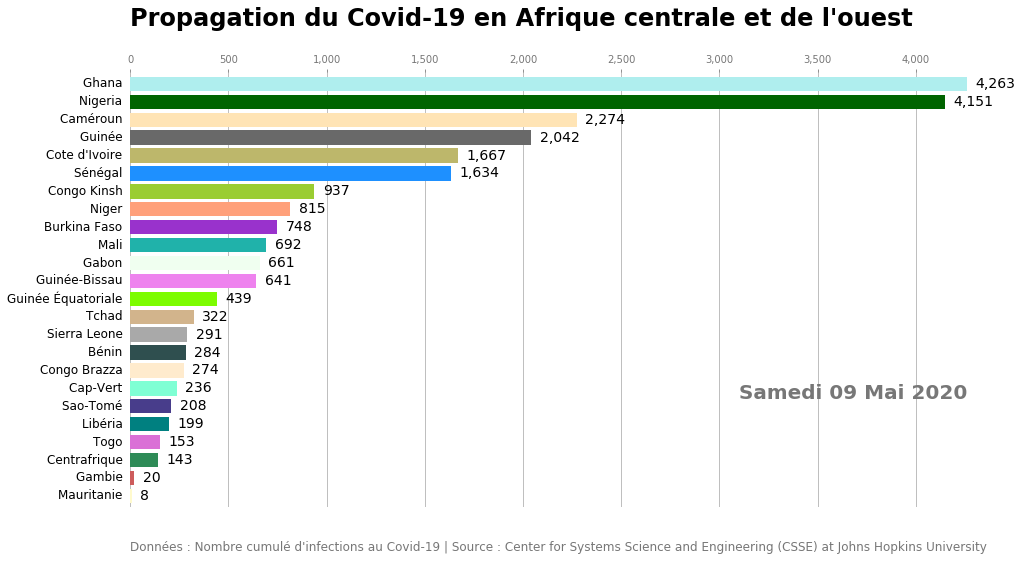

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

def diagramme_band(jour):
    '''
    table = le nom de votre table de données
    c_pays = la colonne contenant les noms des pays
    c_nombre = la colonne contenant le nombre de cas cumulés
    c_jour = la colonne contenant le nombre de jour de l'année
    c_date = la colonne ccontenant les dates complètes
    jour = le jour de l'année dont vous voulez visualiser les données
    '''
    table = west_cent 
    c_pays = 'Pays'
    c_nombre = 'Cas'
    c_jour = 'Jour'
    c_date = 'Date'
    
    data = table[table[c_jour].eq(jour)].sort_values(by= c_nombre, ascending=True).tail(len(table[c_pays].unique()))
    ax.clear()
    ax.barh(data[c_pays], data[c_nombre], color=[couleur_dic[x] for x in data[c_pays]])
    dx = data[c_nombre].max()/ 100
    for i, (value, name) in enumerate(zip(data[c_nombre], data[c_pays])):
        ax.text(0, i, f'{name}  ',  size=12, weight=500, ha='right', va='center')
        ax.text(value+dx, i, f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.25, date_dic[jour], transform=ax.transAxes, color='#777777', size=20, ha='right', weight=800)
    ax.text(0, - 0.1, "Données : Nombre cumulé d'infections au Covid-19 | Source : Center for Systems Science and Engineering (CSSE) at Johns Hopkins University", transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=10)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, "Propagation du Covid-19 en Afrique centrale et de l'ouest",
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)
    
diagramme_band(west_cent['Jour'].max())

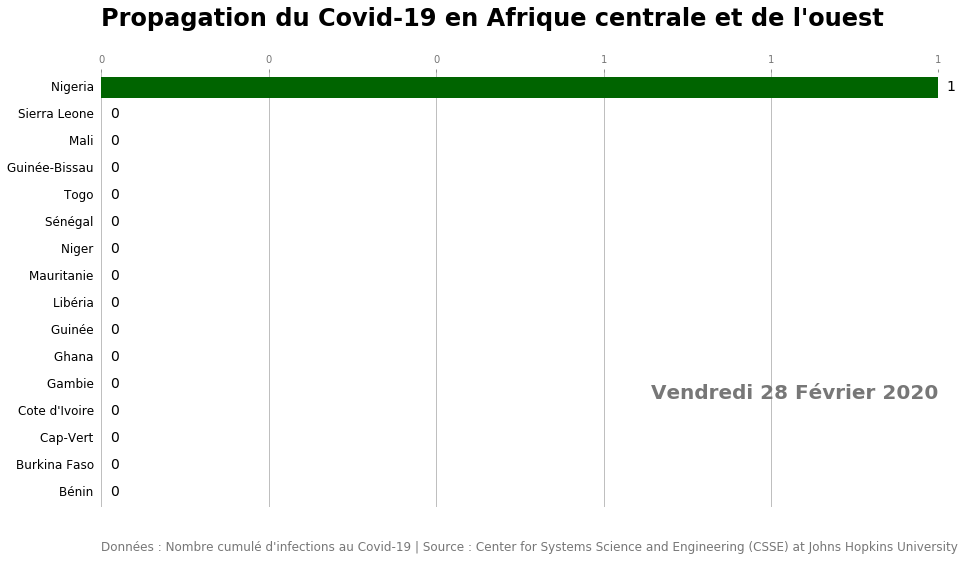

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
viz_animation = animation.FuncAnimation(fig, diagramme_band, frames=range(west_cent['Jour'].min(), west_cent['Jour'].max()+1))

Le code suivant me permet de sauvegarder l'animation en format gif. le paramètre fps désigne le nombre de visualisations que je veux faire défiler par seconde. Moi j'ai choisi 2 mais si vous voulez que votre gif soit plus rapide, vous pouvez augmenter le nombre.

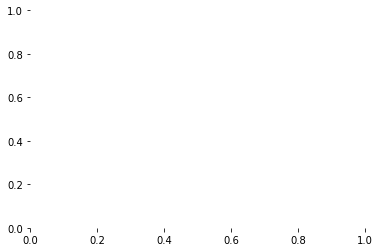

In [16]:
viz_animation.save('images/covid19-west_cent-africa.gif', writer='imagemagick', fps=2)

<img src="images/covid19-west_cent-africa.gif">

Et c'est tout. Vous avez sûrement constaté que des pays se sont affichés avec le nombre 0 durant certains jours. Vous pouvez décider de ne visualiser que les jours où le nombre est supérieur à 0 dans ces pays. Pour ce faire, il vous faudra spécifier cela dans le code du bloc 14. Amusez-vous 😉 !